<a href="https://colab.research.google.com/github/extrajp2014/DS-Unit-2-Sprint-2-Linear-Regression/blob/master/module4-Model%20Diagnostics/Model_Diagnostics_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Diagnostics

The purpose of this assigment is introduce you to a new library for linear regression called statmodels which is much better suited for inferential modeling than sklearn. This assignment is also to familiarize yourself with some of most important procedures for improving the interpretability of regression coefficients. You will also perform important statistical tests that will help establish that whether or not important assumptions that safeguard the interpretability of OLS coefficients have been met. 

We will continue to use the Ames Housing Dataset so that you can focus on the techniques and not on cleaning/getting associated with a brand new dataset.

## 1.1 Choose an X and Y variable from your dataset and use them to create a Seaborn Regplot

In [50]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')
df.head().T

,0,1,2,3,4
Id,1,2,3,4,5
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65.0,80.0,68.0,60.0,84.0
LotArea,8450,9600,11250,9550,14260
Street,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,IR1,IR1,IR1
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub


,0,1,2,3,4
Id,1.0,2.0,3.0,4.0,5.0
MSSubClass,60.0,20.0,60.0,70.0,60.0
LotFrontage,65.0,80.0,68.0,60.0,84.0
LotArea,"8,450.0","9,600.0","11,250.0","9,550.0","14,260.0"
OverallQual,7.0,6.0,7.0,7.0,8.0
OverallCond,5.0,8.0,5.0,5.0,5.0
YearBuilt,"2,003.0","1,976.0","2,001.0","1,915.0","2,000.0"
YearRemodAdd,"2,003.0","1,976.0","2,002.0","1,970.0","2,000.0"
MasVnrArea,196.0,0.0,162.0,0.0,350.0
BsmtFinSF1,706.0,978.0,486.0,216.0,655.0


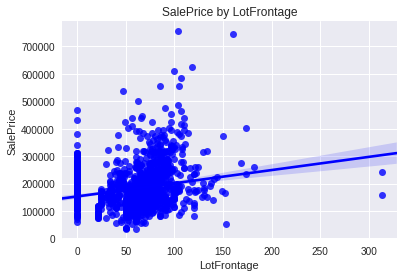

In [43]:
# data source
temp = df[list(df.select_dtypes(include=[np.number]))].copy()
temp.fillna(0, inplace=True)
fig = sns.regplot(temp['LotFrontage'], temp['SalePrice'], color='blue').set_title('SalePrice by LotFrontage')
temp.head().T

## 1.2 Now using the X variables that you feel like will be the best predictors of y use statsmodel to run the multiple regression between these variables and Y. You don't need to use every X variable in your dataset, in fact it's probably better if you don't. Just pick ones that you have already cleaned that seem the most relevant to house prices.

In [44]:
# 1.2 Now using the X variables that you feel like will be the best predictors of y 
# use statsmodel to run the multiple regression between these variables and Y. 
# You don't need to use every X variable in your dataset, in fact it's probably 
# better if you don't. Just pick ones that you have already cleaned that seem the 
# most relevant to house prices.

X = temp.drop(columns= ['SalePrice','Id',"YearBuilt","YearRemodAdd", 'YrSold'], axis=1)
y = temp.loc[:, ['SalePrice']]
print(temp.drop(columns= ['SalePrice','Id',"YearBuilt","YearRemodAdd", 'YrSold'], axis=1).columns)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold'], dtype='object')


In [45]:
# Use Statsmodels to run a regression
X = sm.add_constant(X) # Same as using np.ones to add a vector of ones
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     195.9
Date:                Thu, 21 Feb 2019   Prob (F-statistic):               0.00
Time:                        21:36:55   Log-Likelihood:                -17333.
No. Observations:                1460   AIC:                         3.473e+04
Df Residuals:                    1428   BIC:                         3.490e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.986e+04   1.04e+04     -4.771

## 1.3 Identify the standard errors and P-Values of these coefficients in the output table. What is the interpretation of the P-values here?

* Features with p-values  < 0.05 means that we can reject the null hypothesis, which originally assumes that there is no significant difference in effect between variable x and y.  
* High standard errors  makes estimates of our coefficients less precise.

## 1.4 Remove outliers from your dataset and run the regression again. Do you see a change in some coefficients? Which seem to move the most?

In [46]:
# 1.4 Remove outliers from your dataset and run the regression again. 
# Do you see a change in some coefficients? Which seem to move the most?

print(temp.shape)
temp = temp[(np.abs(stats.zscore(temp)) < 3).all(axis=1)]
print(temp.shape)
X = temp.drop(columns= ['SalePrice','Id',"YearBuilt","YearRemodAdd", 'YrSold'], axis=1)
y = temp.loc[:, ['SalePrice']]

# Use Statsmodels to run a regression
X = sm.add_constant(X) # Same as using np.ones to add a vector of ones
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

(1460, 38)
(973, 38)
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     237.5
Date:                Thu, 21 Feb 2019   Prob (F-statistic):               0.00
Time:                        21:37:00   Log-Likelihood:                -11109.
No. Observations:                 973   AIC:                         2.228e+04
Df Residuals:                     944   BIC:                         2.242e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MSSubClass     -102.4467 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## 1.5 Create a new log(y) variable and use it to run a log-linear regression of your variables using statmodels 




In [109]:
## 1.5 Create a new log(y) variable and use it to run a log-linear regression of your variables using statmodels 

X = temp.drop(columns= ['SalePrice','Id',"YearBuilt","YearRemodAdd", 'YrSold'], axis=1)
y = np.log(temp["SalePrice"])

# Use Statsmodels to run a regression
X = sm.add_constant(X) # Same as using np.ones to add a vector of ones
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     255.8
Date:                Thu, 21 Feb 2019   Prob (F-statistic):               0.00
Time:                        22:37:34   Log-Likelihood:                 688.52
No. Observations:                 973   AIC:                            -1319.
Df Residuals:                     944   BIC:                            -1178.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MSSubClass       -0.0003      0.000     -2.310

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## 2.1 Run a test for high levels of collinearity in your dataset. Calculate the Variance Inflation Factor for each X variable. Do you see VIF values greater than ten? If so try omitting those X variables and run your regression again. Do the standard errors change? Do the coefficients change? Do the coefficients seem to have an interpretation that matches your intuition?

In [110]:
# 2.1 Run a test for high levels of collinearity in your dataset. Calculate the 
# Variance Inflation Factor for each X variable. Do you see VIF values greater 
# than ten? If so try omitting those X variables and run your regression again. 
# Do the standard errors change? Do the coefficients change? Do the coefficients 
# seem to have an interpretation that matches your intuition?

# Calculate the Variance Inflation Factor for each X variable
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X.values, i ) for i in range(X.shape[1])]
print(vif)
for i,j in enumerate(vif):
  if vif[i] > 10: print(X.columns[i],vif[i])

[2.1196308977741776, 1.2444544438766014, 1.8127464511521212, 2.9598549988396528, 1.2306721408935728, 1.3055790787588724, inf, inf, inf, inf, inf, inf, inf, inf, 2.1201283379149616, nan, 2.972254044076251, 2.4203005425197874, 2.3984392395007403, 19752.016186699886, 4.134028813418311, 1.4703895429021885, 3.125877789265653, 4.203933075596229, 3.8865158200767276, 1.181390623976218, 1.3039815107425916, 1.1917241085419061, 1.0147320146026402, 1.0529408150101014, nan, 1.0744384408793881, 1.0382249234750338]
BsmtFinSF1 inf
BsmtFinSF2 inf
BsmtUnfSF inf
TotalBsmtSF inf
1stFlrSF inf
2ndFlrSF inf
LowQualFinSF inf
GrLivArea inf
KitchenAbvGr 19752.016186699886


/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1386: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


## 2.2 Variables that have high levels of multicollinearity should also be highly correlated with each other. Calculate your X matrix's correlation matrix to check if the variables highlighted by the VIF test truly are highly correlated.

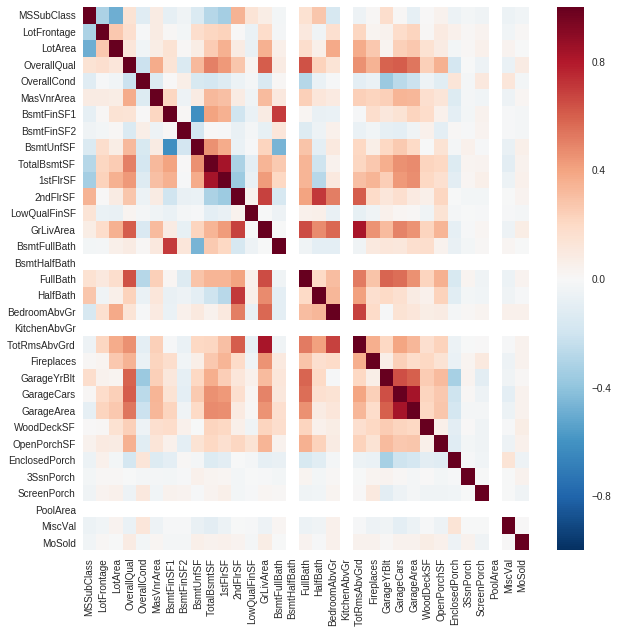

In [111]:
# 2.2 Variables that have high levels of multicollinearity should also be highly 
# correlated with each other. Calculate your X matrix's correlation matrix to check 
# if the variables highlighted by the VIF test truly are highly correlated.
fig = plt.figure(figsize=(10, 10))
sns.heatmap(X.corr());

## 2.3 If you have variables with high Variance Inflation Factors, try excluding them from your regression. Do your standard errors improve? (get smaller). If high levels of multicollinearity are removed, the precision of the dataset should increase.

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold'], dtype='object')
[2.1196308977741776, 1.2444544438766014, 1.8127464511521212, 2.9598549988396528, 1.2306721408935728, 1.3055790787588724, inf, inf, inf, inf, inf, inf, inf, inf, 2.1201283379149616, nan, 2.972254044076251, 2.4203005425197874, 2.3984392395007403, 19752.016186699886, 4.134028813418311, 1.4703895429021885, 3.125877789265653, 4.203933075596229, 3.8865158200767276, 1.181390623976218, 1.3039815107425916, 1.1917241085419061, 1.0147320146026402, 1.0529408150101014, nan, 1.0744384408793881, 1.0382249234750338]
BsmtFinSF

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1386: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  

[5.029046259509721, 5.062042530348868, 12.709030538505166, 58.30791209555464, 37.589900110213605, 1.7627514919170988, 1.9061506250956253, nan, 24.29612620315244, 2.436709033060124, 39.073418540660754, 64.25555585889178, 2.5587398174050886, 110.18195953540811, 40.59328125667496, 31.9633071445803, 1.955653162780825, 2.064193524001883, 1.2281666848309187, 1.0114911295117863, 1.0902233766839176, nan, 1.0700883913460537, 6.678553233735467]
LotArea 12.709030538505166
OverallQual 58.30791209555464
OverallCond 37.589900110213605
FullBath 24.29612620315244
BedroomAbvGr 39.073418540660754
TotRmsAbvGrd 64.25555585889178
GarageYrBlt 110.18195953540811
GarageCars 40.59328125667496
GarageArea 31.9633071445803
------------
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-sta

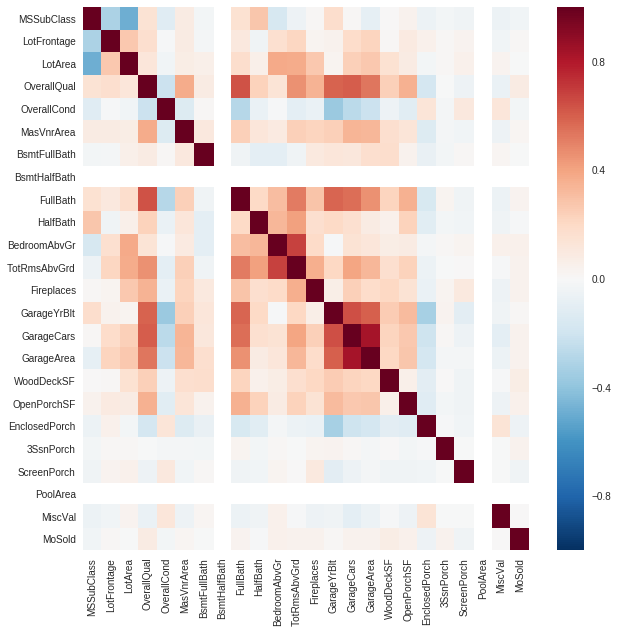

In [130]:
# If you have variables with high Variance Inflation Factors, try excluding them 
# from your regression. Do your standard errors improve? (get smaller). If high levels 
# of multicollinearity are removed, the precision of the dataset should increase.

X = temp.drop(columns= ['SalePrice','Id',"YearBuilt","YearRemodAdd", 'YrSold'], axis=1)
y = np.log(temp["SalePrice"])

print(X.columns)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X.values, i ) for i in range(X.shape[1])]
print(vif)

for i,j in enumerate(vif):
  if vif[i] > 10: print(X.columns[i],vif[i])
print("------------")

# Use Statsmodels to run a regression
X = sm.add_constant(X) # Same as using np.ones to add a vector of ones
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

drop_df = X.drop( columns=['KitchenAbvGr','BsmtFinSF1','BsmtFinSF2',
                           'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
                           'LowQualFinSF','GrLivArea'] )

X = drop_df

print(X.columns)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(X.values, i ) for i in range(X.shape[1])]
print(vif)
for i,j in enumerate(vif):
  if vif[i] > 10: print(X.columns[i],vif[i])
print("------------")


# Use Statsmodels to run a regression
X = sm.add_constant(X) # Same as using np.ones to add a vector of ones
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

fig = plt.figure(figsize=(10, 10))
sns.heatmap(drop_df.corr());


## 2.4 Recalculate your regression using Robust Standard Errors? What happens to your standard errors?

In [98]:
# Robust Standard Errors
################################ 
X = sm.add_constant(X) # Same as using np.ones to add a vector of ones
model = sm.OLS(y, X).fit(cov_type='HC3')
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)
# Recalculate your regression using Robust Standard Errors? What happens to your standard errors?
# return higher standard errors and lower P-values

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                 3.753e+05
Date:                Thu, 21 Feb 2019   Prob (F-statistic):               0.00
Time:                        22:22:46   Log-Likelihood:                 560.15
No. Observations:                 973   AIC:                            -1078.
Df Residuals:                     952   BIC:                            -975.8
Df Model:                          20                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.2489      0.762      8.203

## 2.5 Use scatterplots or Seaborn's pairplot functionality to perform an eyeball test for potential variables that would be candidates for generating polynomial regressors. 

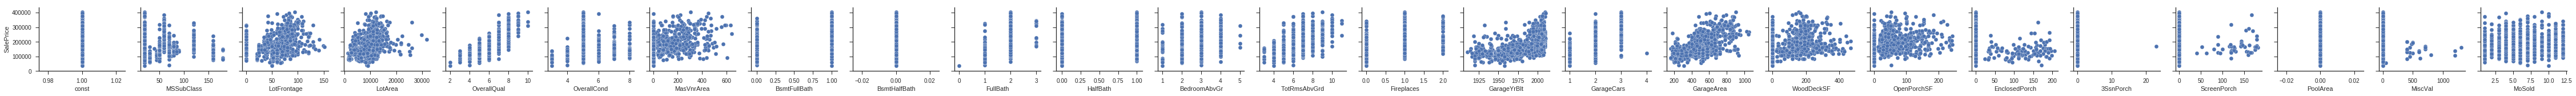

In [79]:
sns.set(style="ticks", color_codes=True)
# Generate a list of column headers
x_columns = X.columns

X1 = X.copy()
X1['SalePrice']=temp['SalePrice']

# Only plot the scatterplot of x variables with our y variable
fig = sns.pairplot(data=X1, y_vars=['SalePrice'], x_vars=x_columns)

## 2.6 Use seaborn's residplot to plot the distribution of each x variable's residuals. Does these plots indicate any other features that would be potential candidates for polynomial features.

Index(['const', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold'], dtype='object')
25


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


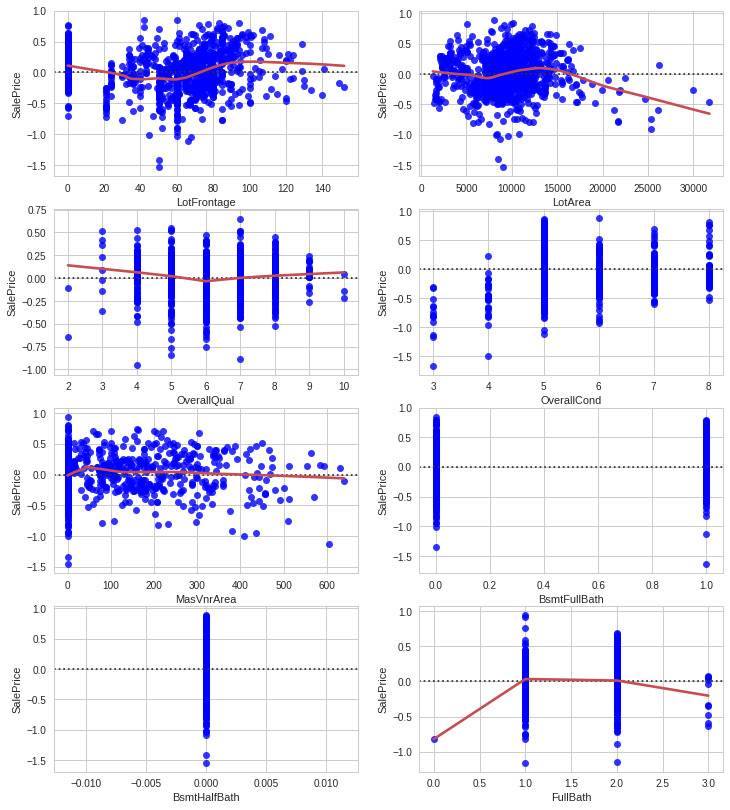

In [150]:
# 2.6 Use seaborn's residplot to plot the distribution of each x variable's residuals. 
# Does these plots indicate any other features that would be potential candidates for polynomial features.

sns.set(style="whitegrid")
fig, axs = plt.subplots(ncols=2, nrows=4,figsize=(12,14))
print(X.columns)
print(len(X.columns))
sns.residplot(X['LotFrontage'], y, lowess=True, color="r", ax=axs[0][0], scatter_kws={'color':'blue'})
sns.residplot(X['LotArea'], y, lowess=True, color="r", ax=axs[0][1], scatter_kws={'color':'blue'})
sns.residplot(X['OverallQual'], y, lowess=True, color="r", ax=axs[1][0], scatter_kws={'color':'blue'})
sns.residplot(X['OverallCond'], y, lowess=True, color="r", ax=axs[1][1], scatter_kws={'color':'blue'})
sns.residplot(X['MasVnrArea'], y, lowess=True, color="r", ax=axs[2][0], scatter_kws={'color':'blue'})
sns.residplot(X['BsmtFullBath'], y, lowess=True, color="r", ax=axs[2][1], scatter_kws={'color':'blue'})
sns.residplot(X['BsmtHalfBath'], y, lowess=True, color="r", ax=axs[3][0], scatter_kws={'color':'blue'})
sns.residplot(X['FullBath'], y, lowess=True, color="r", ax=axs[3][1], scatter_kws={'color':'blue'})

# From our residual plots, I think we can suspect that LotFrontage, LotArea, OverallQual might be candidates for polynomial forms.
# They all have bow form.

## 2.6 Feature Engineer the appropriate polynomial features from your analysis above and include them in one final log-polynomial, robust standard error, regression. Do the coefficients of this most advanced regression match your intuition better than the coefficients of the very first regression that we ran with the Statmodels library?

In [151]:
# 2.6 Feature Engineer the appropriate polynomial features from your analysis above 
# and include them in one final log-polynomial, robust standard error, regression. 
# Do the coefficients of this most advanced regression match your intuition better 
# than the coefficients of the very first regression that we ran with the Statmodels library?
# The std error decrease on squared features and R-squared was increased by 0.001.

X['sqft_LotFrontage'] = X['LotFrontage']**2
X['sqft_LotArea'] = X['LotArea']**2
X['sqft_OverallQual'] = X['OverallQual']**2

# Robust Standard Errors
################################ 
X = sm.add_constant(X) # Same as using np.ones to add a vector of ones
model = sm.OLS(y, X).fit(cov_type='HC3')
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                 3.166e+05
Date:                Thu, 21 Feb 2019   Prob (F-statistic):               0.00
Time:                        23:30:37   Log-Likelihood:                 562.82
No. Observations:                 973   AIC:                            -1074.
Df Residuals:                     947   BIC:                            -946.7
Df Model:                          25                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.1953      0.749  

# Stretch Goals

- Research the assumptions that are required for OLS to be BLUE the "Best Linear Unbiased Estimator". You might try searching and trying to understand the conditions of what's called the Gauss-Markov Theorem.
- Research other Diagnostic tests. Can you show that residuals are normally distributed graphically?
- Study for the sprint challenge!
- Write a blog post about iferential modeling using linear regression.